In [187]:
import numpy as np
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import matplotlib.ticker as ticker

import panel as pn
#pn.extension()

pn.extension('tabulator')
#from numpy.ma import masked_array as ma"
import numpy.ma as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit
import time
#import numpy.ma as ma 
%load_ext autoreload
%autoreload 2 

from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np
import os
import param

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit

plt.rcParams.update({
                    'font.size': 16,
                    'font.family': 'serif',
                    'axes.labelsize': 16,
                    'axes.titlesize': 16,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': 14,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})


from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u


def gauss_scint(x,bw,amp,off):
    return off + amp*np.exp(-np.log(2)*((x/bw)**2))


def lorentz_scint(x,bw,amp,off):
    return off + amp*(bw/(x**2 + (0.5*bw**2)))

fsize=30
fsize2=20
plt.rcParams.update({
                    'font.size': fsize,
                    'font.family': 'sans-serif',
                    'axes.labelsize': fsize,
                    'axes.titlesize': fsize,
                    'xtick.labelsize': fsize,
                    'ytick.labelsize': fsize,
                    'xtick.direction': 'in',
                    'ytick.direction': 'in',
                    'xtick.top': True,
                    'ytick.right': True,
                    'lines.linewidth': 1,
                    'lines.markersize': 5,
                    'legend.fontsize': fsize2,
                    'legend.borderaxespad': 0,
                    'legend.frameon': False,
                    'legend.loc': 'lower right'})

#testing with RM table: https://github.com/CIRADA-Tools/RMTable
from rmtable import RMTable
#testing with pol Table: https://github.com/CIRADA-Tools/PolSpectra/tree/master
import polspectra
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#import functions from polarization modules
from pol_panel_funcs import pol_plot
from pol_panel_funcs import pol_panel
from RM_panel_funcs import RM_plot
from RM_panel_funcs import RM_panel
#import functions from usage module
import usage_panel_funcs

#import functions from dedisp module
from dedisp_panel_funcs import dedisp_plot
from dedisp_panel_funcs import dedisp_panel

import dsarp_interface

In [177]:
#build panel functions

def build_dedisp_tab():
    
    
    # make dropdown box to choose FRB file
    x=os.listdir("/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us") 
    FRB_list = []
    for i in range(len(x)):
        if len(x[i]) >= 10 and x[i][10] == "_":
            FRB_list.append(x[i])

    menu_calplots = pn.widgets.MenuButton(name="Select FRB to Load",
                                          items=FRB_list,
                                         width=200)
    
    # make dropdown box to choose beamformer weights
    x=os.listdir("/dataz/dsa110/operations/beamformer_weights/applied")
    bf_list = []
    for i in range(len(x)): #beamformer_weights_sb07_2022-10-21T00:41:56.dat
        if "sb01" in x[i]:
            bf_list.append(x[i][24:43])
    bf_list.sort()
    bf_list = bf_list[::-1]
    
    menu_bf = pn.widgets.MenuButton(name="Select Beamformer Weights",
                                      items=bf_list,
                                     width=200)
    
    #load_button = pn.widgets.Button(name='Load FRB', width=100, button_type='primary')
    DM_input = pn.widgets.FloatInput(name='Input DM (pc/cc)', value=0, step=1e-2, start=0, end=10000)
    #ibeam_input = pn.widgets.IntSlider(name='ibeam', start=0, end=250, step=1, value=0)
    mjd_input = pn.widgets.TextInput(name='mjd',placeholder='Enter mjd here')
    

    #create polarization pane and links for initialization
    pane_test = pn.pane.Markdown('# DSA-110 Dedispersion Tuning Dashboard')
    pan1 = dedisp_panel()
    
    menu_calplots.link(pan1, clicked='frb_name')
    menu_bf.link(pan1,clicked='caldate')
    #load_button.link(pan1,callbacks={'clicks': callback})#pan1, clicks='frb_submitted')
    DM_input.link(pan1,value='DM')
    #ibeam_input.link(pan1,value='ibeam')
    mjd_input.link(pan1,value='mjd')
    
    

    c1 = pn.Column(pane_test,
              pn.Row(pn.Column(menu_calplots,
                               pan1.param.frb_name,
                               pan1.param.ibeam,
                               pan1.param.load_button,
                               pan1.param.n_t,
                              pan1.param.log_n_f,
                              pan1.param.window,
                              pan1.param.perc),
                     pn.Column(menu_bf,
                               pan1.param.caldate,
                               mjd_input,
                               pan1.param.error,
                               DM_input,
                              pan1.param.ddm_str,
                              pan1.param.final_DM_str,
                              pan1.param.ddmdelay_str,
                              pan1.param.applyb,
                              pan1.param.recompute_filterbanks)))

    return pn.Row(c1,pan1.view)#pn.Column(pane_test,pn.Row(menu_calplots,menu_bf,pan1.param.load_button,pan1.param.ibeam,mjd_input),pn.Row(DM_input),pn.Row(pan1.param,pan1.view))

def build_pol_tab():
    
    # make dropdown box to choose FRB file
    x=os.listdir("/media/ubuntu/ssd/sherman/scratch_weights_update_2022-06-03_32-7us") 
    FRB_list = []
    for i in range(len(x)):
        if len(x[i]) >= 10 and x[i][10] == "_":
            FRB_list.append(x[i])

    menu_calplots = pn.widgets.MenuButton(name="Select FRB to Load",
                                          items=FRB_list,
                                         width=300)
    
    #load_button = pn.widgets.Button(name='Load FRB', width=100, button_type='primary')
    
    # make dropdown box to choose calibration file
    y = os.listdir("/media/ubuntu/ssd/sherman/code")
    CAL_list = []
    
    for i in range(len(y)):
        if ("POLCAL_PARAMETERS" in y[i]) and ("csv" in y[i]):
            CAL_list.append(y[i])
    calmenu_calplots = pn.widgets.MenuButton(name="Select Calibration File to Load",
                                      items=CAL_list,
                                     width=300)
    
    #calibration button and beam, RA, dec input for PA calibration
    RA_input = pn.widgets.FloatInput(name='RA (degrees)', value=0, step=1e-2, start=0, end=360)
    DEC_input = pn.widgets.FloatInput(name='DEC (degrees)', value=0, step=1e-2, start=-90, end=90)
    MJD_input = pn.widgets.FloatInput(name='MJD', value=0, step=1e-8, start=0, end=Time.now().mjd)

    #create polarization pane and links for initialization
    pane_test = pn.pane.Markdown('# DSA-110 Polarization Dashboard')
    pan1 = pol_panel()
    
    #clear temp data at start of each session
    pan1.clicked_clear()
    
    menu_calplots.link(pan1, clicked='frb_name')
    
    calmenu_calplots.link(pan1,clicked='cal_name')
    RA_input.link(pan1,value='RA')
    DEC_input.link(pan1,value='DEC')
    MJD_input.link(pan1,value='MJD')
    
    pane_test = pn.pane.Markdown('# DSA-110 Polarization Dashboard')
  
    
    c1 = pn.Column(pane_test,
        pn.Row(pan1.param.load_polcal,pan1.param.load_RMcal),
        pn.Row(menu_calplots,calmenu_calplots,RA_input),
        pn.Row(pan1.param.frb_name,pan1.param.cal_name,DEC_input),
        pn.Row(pan1.param.load_button,pan1.param.cal_button,MJD_input),
        pn.Row(pan1.param.savefil_button,pan1.param.savefilRM_button,pan1.param.ibeam),
        pn.Row(pan1.param.savetxt_button,pan1.param.savejson_button),
        pn.Row(pn.Column(pan1.param.error,
                         pan1.param.error2,
                         pan1.param.n_t,
                         pan1.param.buff_L,
                         pan1.param.buff_R,
                         pan1.param.log_n_t_weight,
                         pan1.param.sf_window_weights,
                         pan1.param.ibox,
                         pan1.param.comp_width,
                         pan1.param.log_n_f,
                         pan1.param.lo_frac,
                         pan1.param.multipeaks,
                         pan1.param.maskPA,
                         pan1.param.height,
                         pan1.param.next_comp,
                         pan1.param.get_comp,
                         pan1.param.done,
                         pan1.param.exportplot,width=320),
               pn.Column(pan1.param.snr,
                          pan1.param.Tsnr,
                          pan1.param.Tpol,
                          pan1.param.Tpolerr,
                          pan1.param.Lsnr,
                          pan1.param.Lpol,
                          pan1.param.Lpolerr,
                          pan1.param.Csnr,
                          pan1.param.absCpol,
                          pan1.param.absCpolerr,
                          pan1.param.Cpol,
                          pan1.param.Cpolerr,
                          pan1.param.avgPA,
                          pan1.param.avgPAerr,width=320),
              pn.Column(pan1.param.link_button,
                        pan1.param.RMdata_init,
                        pan1.param.RMcal_button,
                        pan1.param.clear_data,
                        width=320)))
        
    #create display for Pol Spectra tables and initialize
    spec_pre_init = polspectra.from_FITS(dsarp_interface.PolSpectra_preRM_name)
    d = dict()
    for i in spec_pre_init.columns:
        if spec_pre_init[i].dtype != object:
            d[i] = spec_pre_init[i]

    spec_pre_init_df = pd.DataFrame(d)
    df_widget_pre = pn.widgets.Tabulator(spec_pre_init_df,width=2500)
    
    spec_post_init = polspectra.from_FITS(dsarp_interface.PolSpectra_postRM_name)
    d = dict()
    for i in spec_post_init.columns:
        if spec_post_init[i].dtype != object:
            d[i] = spec_post_init[i]

    spec_post_init_df = pd.DataFrame(d)
    df_widget_post = pn.widgets.Tabulator(spec_post_init_df,width=2500)
    
    
    
    def callback_refresh(event):
        spec_pre = polspectra.from_FITS(dsarp_interface.PolSpectra_preRM_name)
        d = dict()
        for i in spec_pre.columns:
            if spec_pre[i].dtype != object:
                d[i] = spec_pre[i]

        spec_pre_df = pd.DataFrame(d)  
        df_widget_pre.value = spec_pre_df      
        
        
        spec_post = polspectra.from_FITS(dsarp_interface.PolSpectra_postRM_name)
        d = dict()
        for i in spec_post.columns:
            if spec_post[i].dtype != object:
                d[i] = spec_post[i]

        spec_post_df = pd.DataFrame(d)  
        df_widget_post.value = spec_post_df     
        return
    
    

    #create button to refresh table
    refresh_button = pn.widgets.Button(name='Refresh', button_type='primary',width=200)
    refresh_button.on_click(callback_refresh)
    
    r2 = pn.Column(pn.pane.Markdown('# **DSA-110 Pre-RM PolSpectra Catalog**'),
                   refresh_button,
                  df_widget_pre,
                  pn.pane.Markdown('# **DSA-110 Post-RM PolSpectra Catalog**'),
                  df_widget_post)
    
    
    return pn.Column(pn.Row(c1,pan1.view),r2)


def build_RM_tab():
    #clear temp data at start of each session
    
    
    #create RM pane and links for passing data
    pan2 = RM_panel()
    
    
    
    

    pane_test = pn.pane.Markdown('# DSA-110 RM Analysis Dashboard')
    
    c2 = pn.Column(pane_test,pn.Row(pan2.param.fullburst_bool,pan2.param.sigflag),
                   pn.Row(pan2.param.ids,pan2.param.curr_comp_str),
                   pan2.param.threshold,
                   pn.Row(pn.Column(pan2.param.RMdata_init,
                  pan2.param.RMdata_out,
                  pn.pane.Markdown("**Initial RM Synthesis**"),
                  pan2.param.error,
                  pan2.param.RM1_str,
                  pan2.param.RMerr1_str,
                  pan2.param.RM1tools_str,
                  pan2.param.RMerr1tools_str,
                  pn.pane.Markdown("**Fine RM Synthesis**"),
                  pan2.param.RM1zoom_str,
                  pan2.param.RMerr1zoom_str,
                  pan2.param.RM1tools_zoom_str,
                  pan2.param.RMerr1tools_zoom_str,
                  pan2.param.RM2zoom_str,
                  pan2.param.RMerr2zoom_str,
                  pan2.param.clear_data,
                  pan2.param.update_display),
               pn.Column(pan2.param.run,
                        pan2.param.exportplot,
                        pn.pane.Markdown("**Initial RM Synthesis Settings**"),
                        pan2.param.RMmin,
                        pan2.param.RMmax,
                        pan2.param.numRMtrials,
                        pn.pane.Markdown("**Fine RM Synthesis Settings**"),
                        pan2.param.numRMtrials_zoom,
                        pan2.param.zoom_window,
                        pn.pane.Markdown("**Galactic and Ionospheric RM**"),
                        pan2.param.galrm,
                        pan2.param.RM_gal_str,
                        pan2.param.RM_galerr_str,
                        pan2.param.ionrm,
                        pan2.param.RM_ion_str,
                        pan2.param.RM_ionerr_str)))
    
    
    
    #create display for RM table and initialize
    rmtable_init = RMTable.read(dsarp_interface.RMTable_name)
    rmtable_init_df = rmtable_init.to_pandas()

    for col in rmtable_init_df.columns:
        #print(col)
        for i in range(len(rmtable_init_df[col])):
            if type(rmtable_init_df[col][i]) == bytes:
                rmtable_init_df[col][i] = rmtable_init_df[col][i].decode()
                #print(type(rmtable_df[col][i]))    
    df_widget = pn.widgets.Tabulator(rmtable_init_df,width=2500)
        
    
    def callback_refresh(event):
        rmtable = RMTable.read(dsarp_interface.RMTable_name)
        rmtable_df = rmtable.to_pandas()

        for col in rmtable_df.columns:
            #print(col)
            for i in range(len(rmtable_df[col])):
                if type(rmtable_df[col][i]) == bytes:
                    rmtable_df[col][i] = rmtable_df[col][i].decode()
                    #print(type(rmtable_df[col][i]))       
        df_widget.value = rmtable_df      
        return
    
    

    #create button to refresh table
    refresh_button = pn.widgets.Button(name='Refresh', button_type='primary',width=200)
    refresh_button.on_click(callback_refresh)
    
    r2 = pn.Column(pn.pane.Markdown('# **DSA-110 RMTable Catalog**'),refresh_button,
                  df_widget)
    
    
    return pn.Column(pn.Row(c2,pan2.view),r2)


#ADD JAKOB'S CODE HERE FOR BURSTFIT TAB
def burstfit_tab():
    pass
    
    
    
#usage tab

def build_usage_tab():
    
    #dedisp tab
    dedisp_usage = usage_panel_funcs.dedisp_usage_str
    
    #pol tab
    pol_usage = usage_panel_funcs.pol_usage_str
    
    #RM tab
    RM_usage = usage_panel_funcs.RM_usage_str
    
    #burstfit tab
    burstfit_usage = usage_panel_funcs.burstfit_usage_str
    
    
    width=1500
    
    title = """
            # **Burst Analysis Dashboard Usage**
                                      
            ## This page contains instructions and examples for using the Burst Analysis Dashboard
            """
    
    return pn.Column(pn.pane.Markdown(title,width=width),
                     pn.pane.Markdown(dedisp_usage,width=width),
                    pn.pane.Markdown(pol_usage,width=width),
                    pn.pane.Markdown(RM_usage,width=width),
                    pn.pane.Markdown(burstfit_usage,width=width))

In [178]:
pol_pane = pn.param.ParamFunction(build_pol_tab,lazy=True)


In [179]:
RM_pane = pn.param.ParamFunction(build_RM_tab,lazy=True)

In [180]:
usage_pane = pn.param.ParamFunction(build_usage_tab,lazy=True)

In [181]:
dedisp_pane = pn.param.ParamFunction(build_dedisp_tab,lazy=True)
#viewtable_pane = pn.param.ParamFunction(build_viewtable_tab,lazy=True)

In [182]:
dashboard = pn.Column(pn.Row(pn.layout.tabs.Tabs(('Usage', usage_pane),
                                                 ('Dedispersion', dedisp_pane),
                                                 ('Polarization', pol_pane),
                                                 ('RM Analysis', RM_pane),
                                                 #('Burstfit',burstfit_tab),
                                                dynamic=True, active=2),
                             margin=(10, 10, 10, 10), background='#f0f0f0'))

/media/ubuntu/ssd/sherman/code/pol_panel_funcs.py:158: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  paxs[i-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
/media/ubuntu/ssd/sherman/code/pol_panel_funcs.py:160: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  faxs[i-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
/media/ubuntu/ssd/sherman/code/pol_panel_funcs.py:175: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  paxs[-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
/media/ubuntu/ssd/sherman/code/pol_panel_funcs.py:176: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  faxs[-1].set_xlim(np.min(freq_test[0]),np.max(freq_test[0]))
No artists with labels found t

DEBUGGING: 1 1 0 False


Column
    [0] Row(background='#f0f0f0', margin=(10, 10, 10, 10))
        [0] Tabs(active=2, dynamic=True)
            [0] ParamFunction(function, lazy=True)
            [1] ParamFunction(function, lazy=True)
            [2] ParamFunction(function, lazy=True)
            [3] ParamFunction(function, lazy=True)
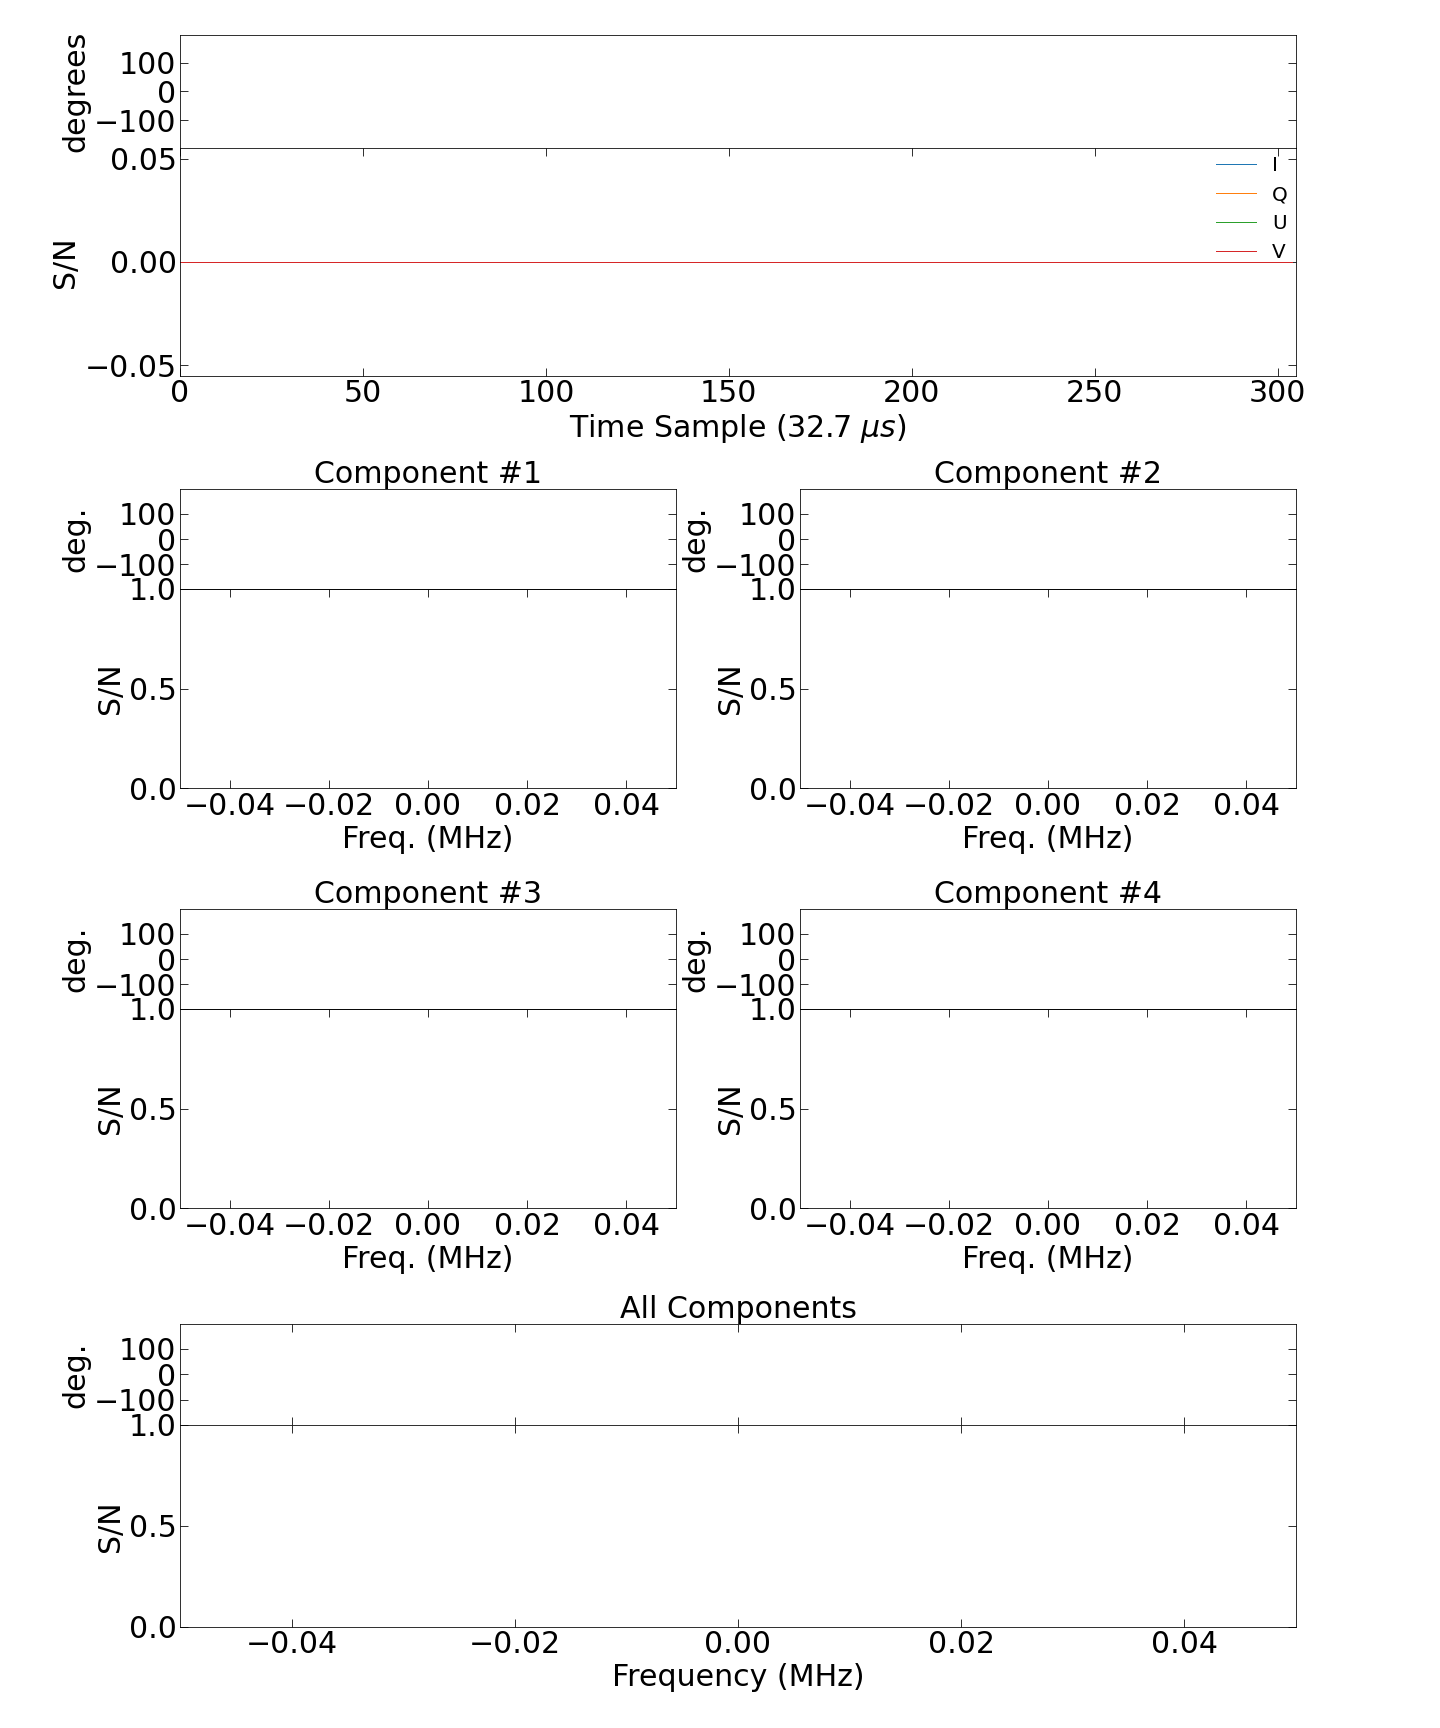

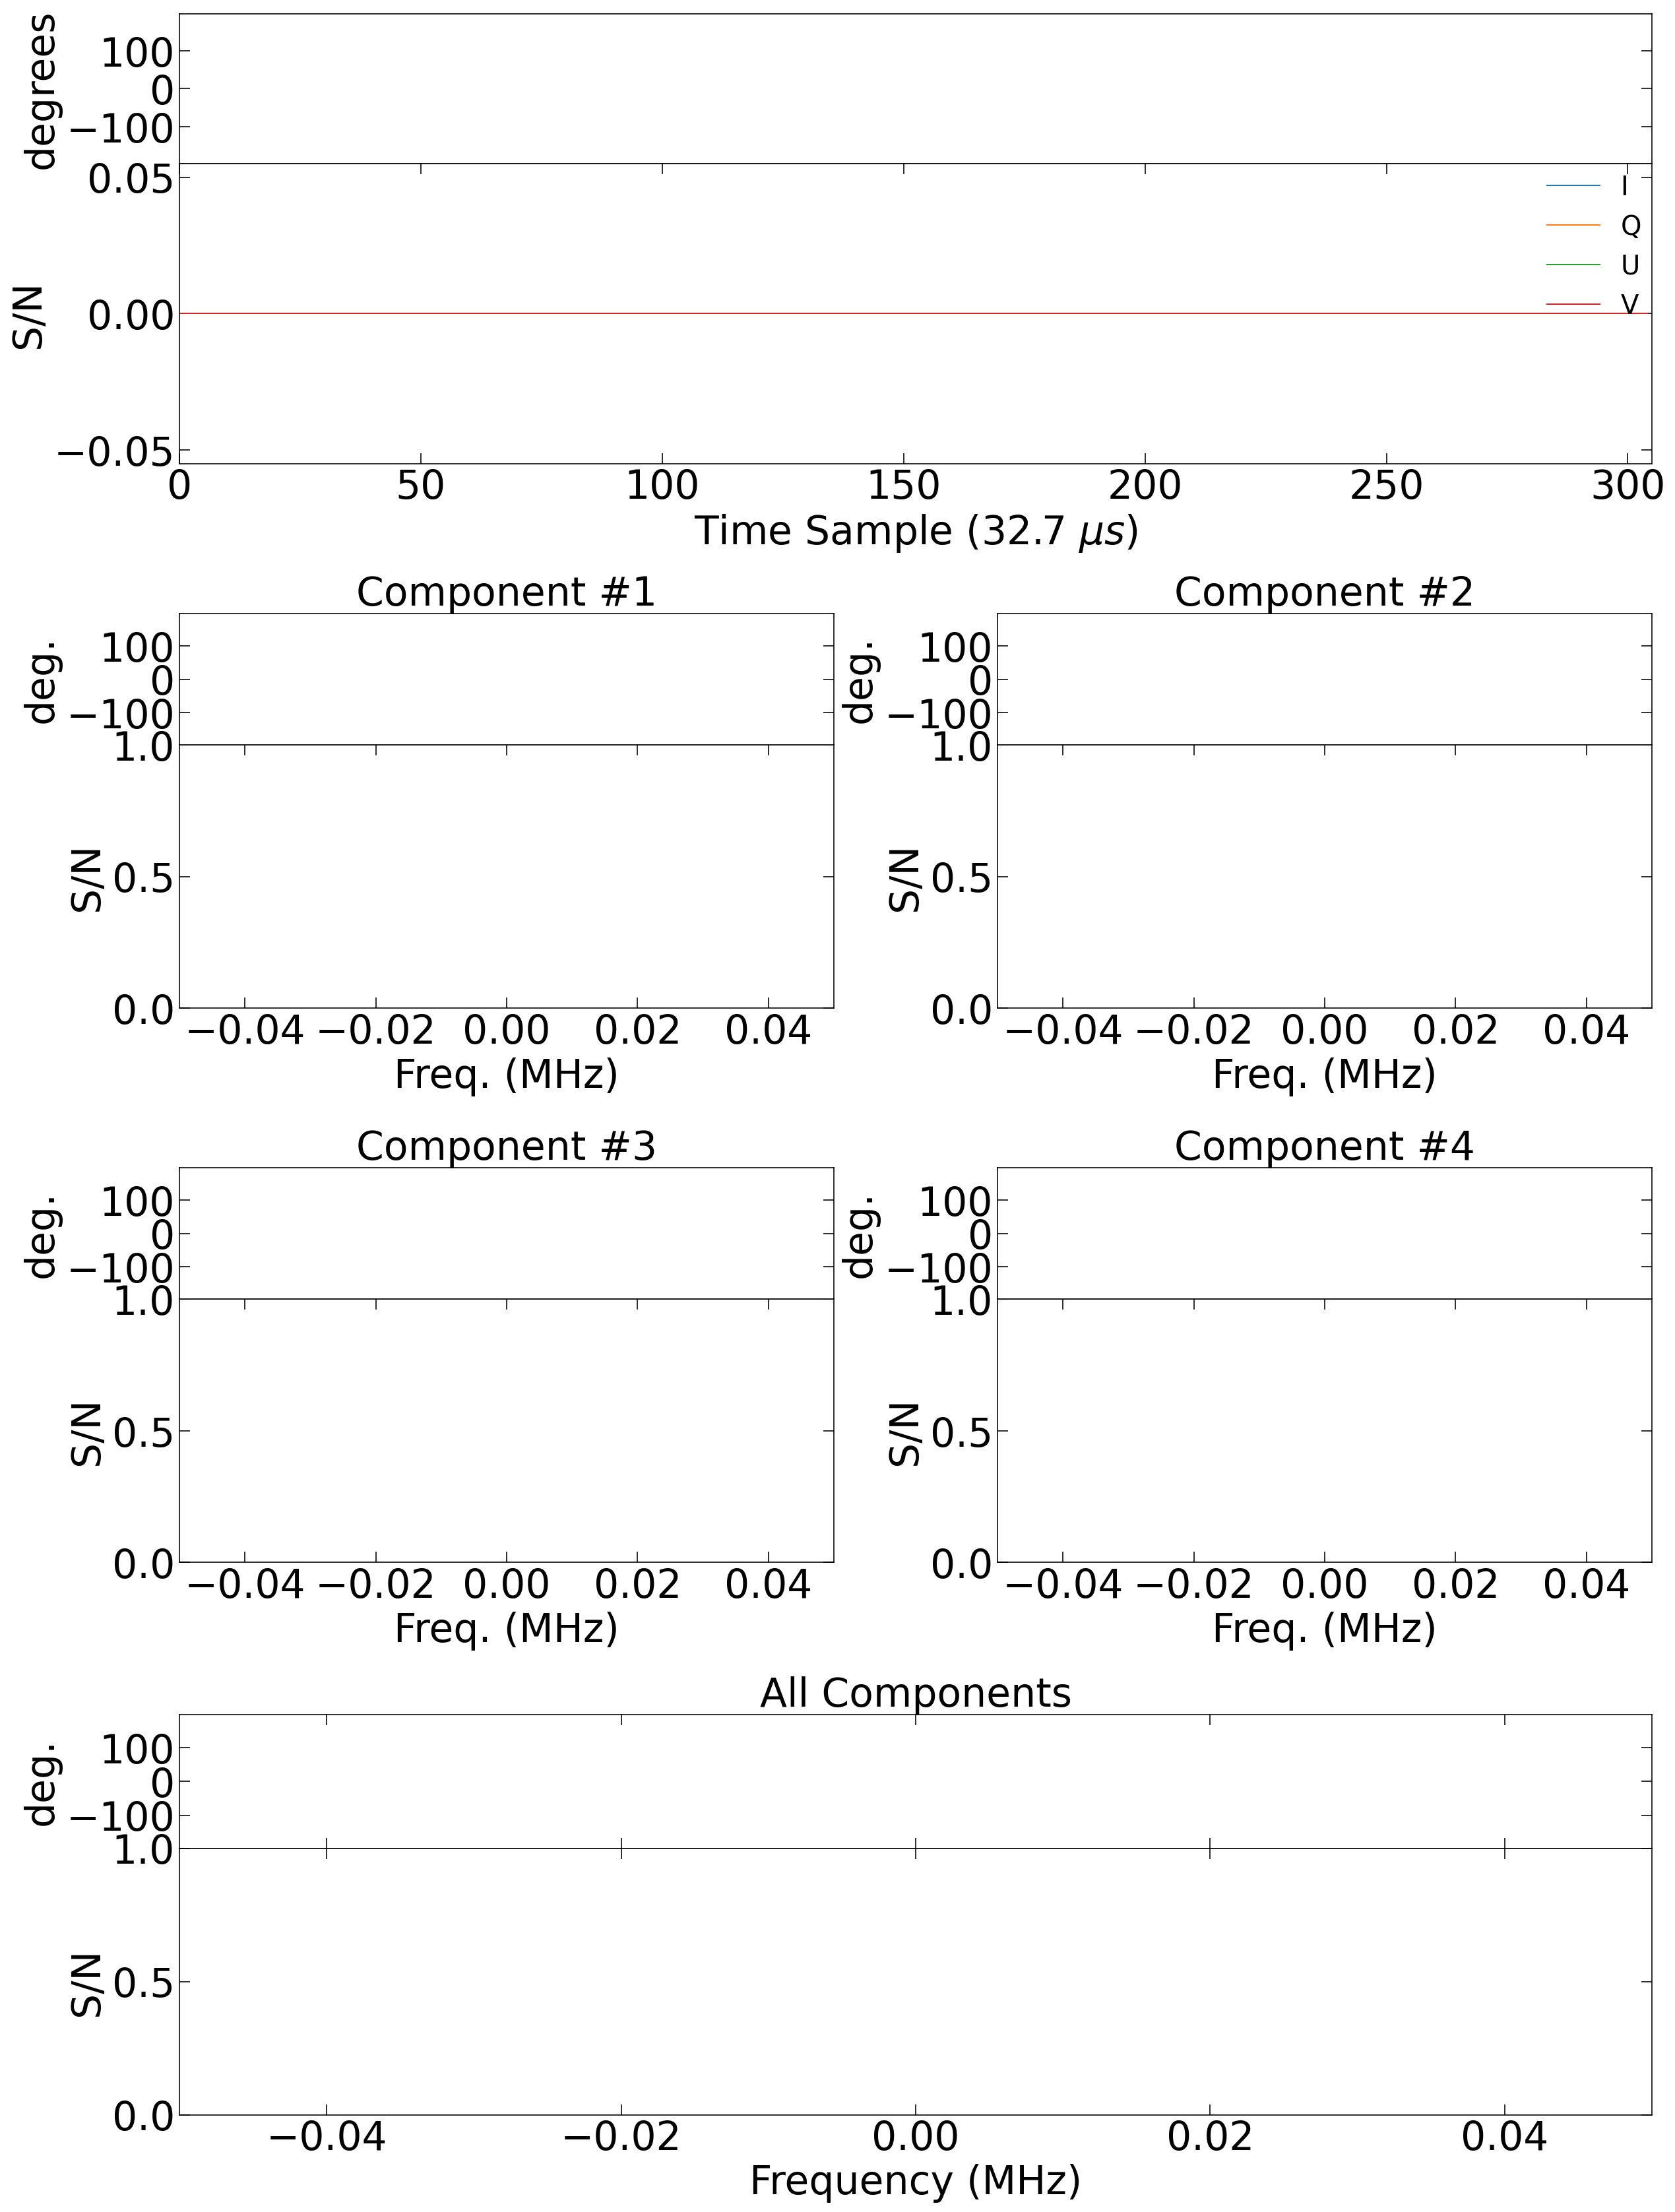

In [183]:
dashboard

Column
    [0] Row(background='#f0f0f0', margin=(10, 10, 10, 10))
        [0] Tabs(active=3, dynamic=True)
            [0] ParamFunction(function, lazy=True)
            [1] ParamFunction(function, lazy=True)
            [2] ParamFunction(function, lazy=True)
            [3] ParamFunction(function, lazy=True)
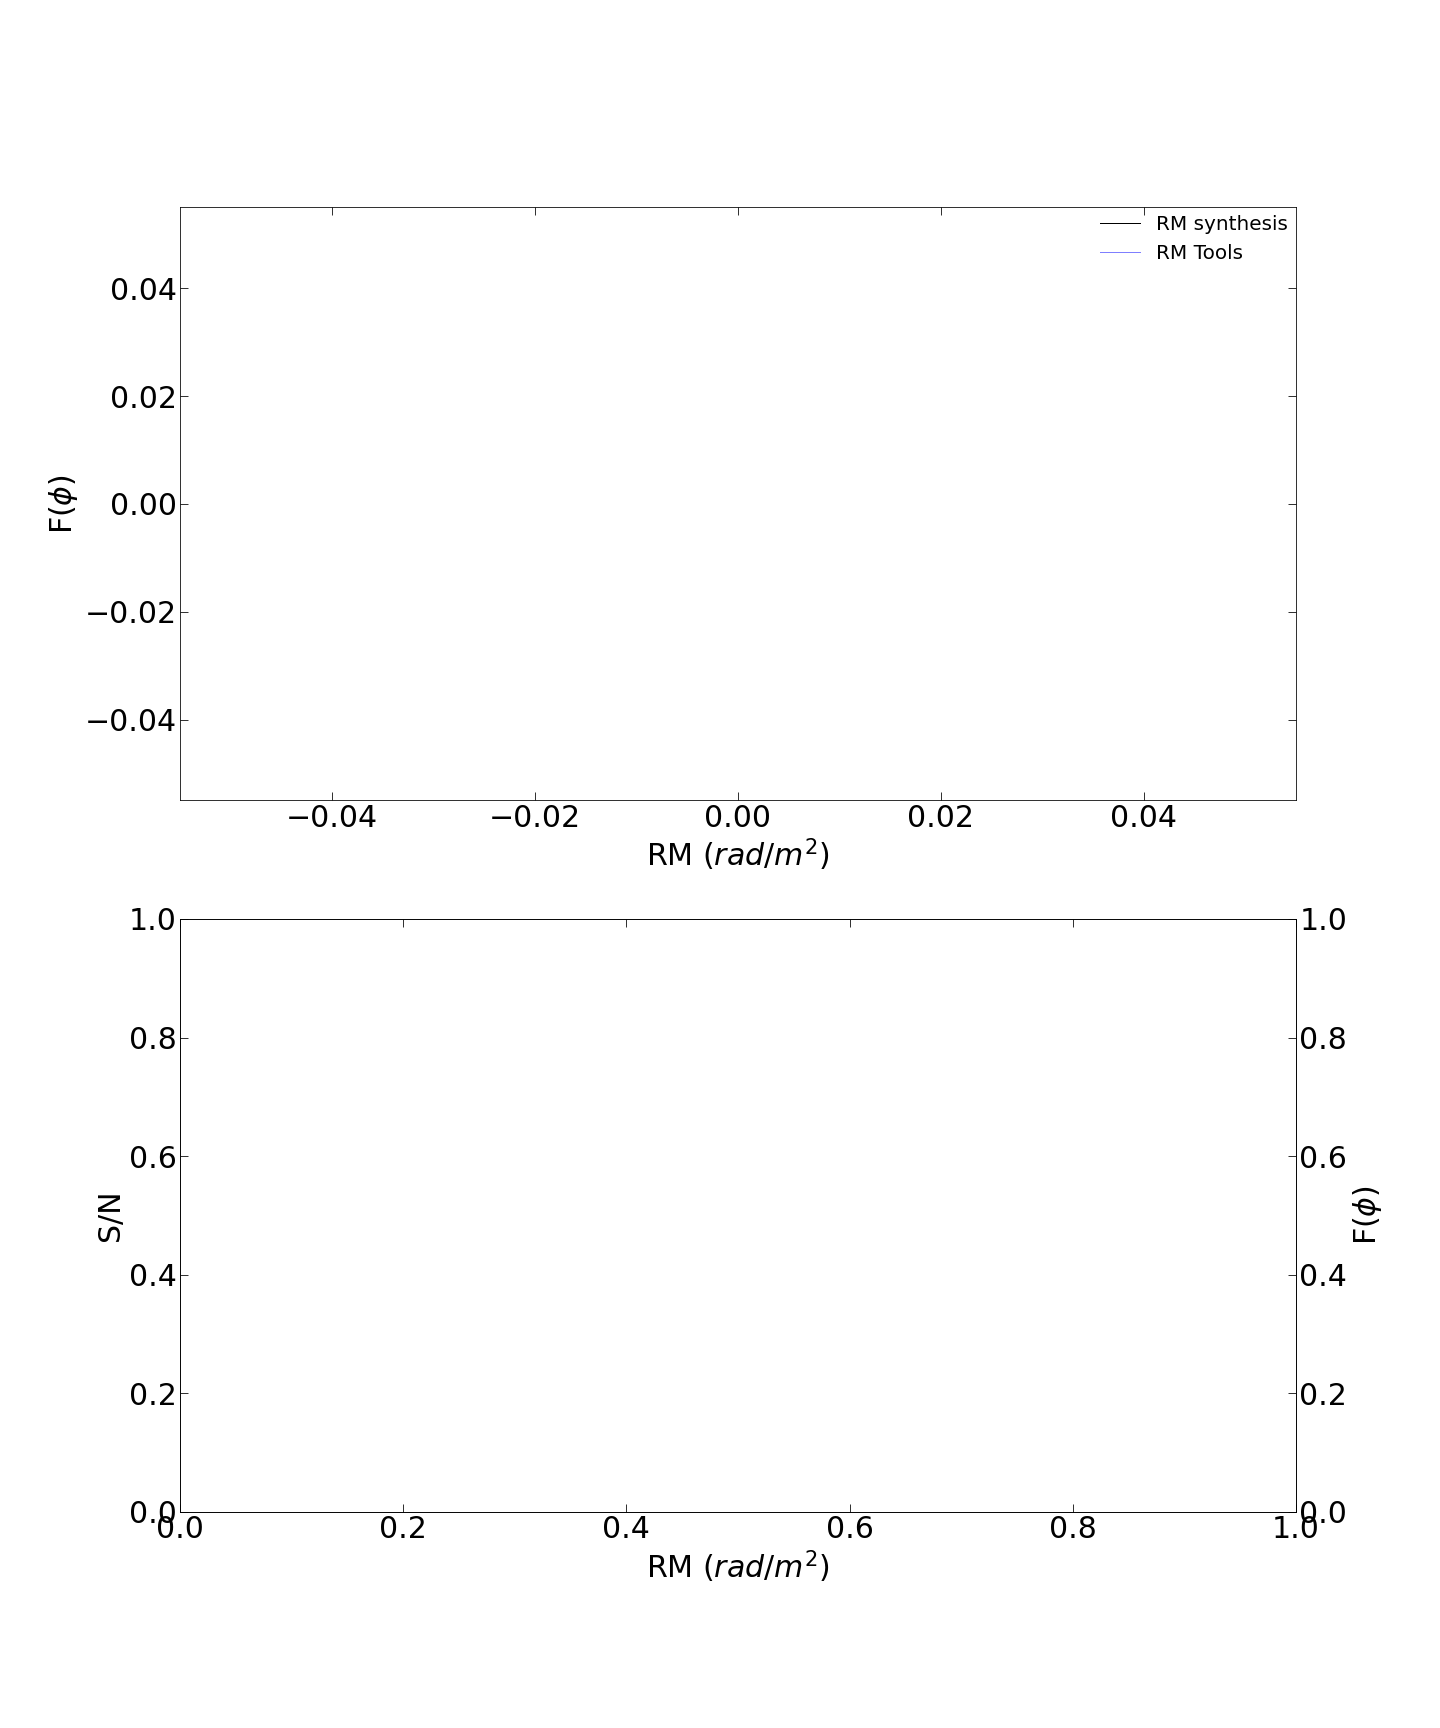

In [186]:
dashboard.servable(title="Burst Analysis Dashboard")